<H1>Comparacion de modelos predictivos similares </H1>

Este Jupyter Notebook demora varias horas en correr
se sugiere solo entender el codigo e interpretar los resultados que genera
los resultados quedan en el repositorio GitHub  /exp/ST1005

In [1]:
rm( list=ls() )  #Borro todos los objetos
gc()   #Garbage Collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,605971,32.4,1317690,70.4,1016737,54.3
Vcells,1132621,8.7,8388608,64.0,1819928,13.9


<H2> Carga de librerias </H2>

In [2]:
require("data.table")
require("rpart")
require("parallel")

require("primes")      #para obtener numeros primos que seran semillas
require("ggplot2")     #para grafiucar las densidades

Loading required package: data.table

Loading required package: rpart

Loading required package: parallel

Loading required package: primes

Loading required package: ggplot2



<H2> Definicion de Funciones </H2>

In [3]:
#particionar agrega una columna llamada fold a un dataset que consiste en una particion estratificada segun agrupa
# particionar( data=dataset, division=c(70,30), agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30 

particionar  <- function( data,  division, agrupa="",  campo="fold", start=1, seed=NA )
{
  if( !is.na(seed) )   set.seed( seed )

  bloque  <- unlist( mapply(  function(x,y) { rep( y, x )} ,   division,  seq( from=start, length.out=length(division) )  ) )  

  data[ , (campo) :=  sample( rep( bloque, ceiling(.N/length(bloque))) )[1:.N],
          by= agrupa ]
}

In [4]:

ArbolEstimarGanancia  <- function( semilla, param_basicos )
{
  #particiono estratificadamente el dataset
  particionar( dataset, division=c(70,30), agrupa="clase_ternaria", seed= semilla )  #Cambiar por la primer semilla de cada uno !

  #genero el modelo
  modelo  <- rpart("clase_ternaria ~ .",     #quiero predecir clase_ternaria a partir del resto
                   data= dataset[ fold==1],  #fold==1  es training,  el 70% de los datos
                   xval= 0,
                   control= param_basicos )  #aqui van los parametros del arbol

  #aplico el modelo a los datos de testing
  prediccion  <- predict( modelo,   #el modelo que genere recien
                          dataset[ fold==2],  #fold==2  es testing, el 30% de los datos
                          type= "prob") #type= "prob"  es que devuelva la probabilidad

  #prediccion es una matriz con TRES columnas, llamadas "BAJA+1", "BAJA+2"  y "CONTINUA"
  #cada columna es el vector de probabilidades 


  #calculo la ganancia en testing  qu es fold==2
  ganancia_test  <- dataset[ fold==2, 
                             sum( ifelse( prediccion[, "BAJA+2"]  >  1/60,
                                         ifelse( clase_ternaria=="BAJA+2", 59000, -1000 ),
                                         0 ) )]

  #escalo la ganancia como si fuera todo el dataset
  ganancia_test_normalizada  <-  ganancia_test / 0.3

  return( ganancia_test_normalizada )
}

In [5]:

ArbolesMontecarlo  <- function( semillas,  param_basicos )
{
  ganancias  <- mcmapply( ArbolEstimarGanancia, 
                          semillas,   #paso el vector de semillas, que debe ser el primer parametro de la funcion ArbolEstimarGanancia
                          MoreArgs= list( param_basicos),  #aqui paso el segundo parametro
                          SIMPLIFY= FALSE,
                          mc.cores= 16 )  #se puede subir a 5 si posee Linux o Mac OS

  #media de las ganancias
  return(  unlist(ganancias) )
}

<H2>Aqui comienza el programa<H2>

Establezco el working directory

In [6]:
setwd("/media/Shared/gustavo/b1/")

Cargo el dataset

In [7]:
dataset  <- fread("./datasets/paquete_premium_202011.csv")

Defino los modelos que quiero comparar

In [8]:
paramA  <- list( "cp"=         -1,  #complejidad minima
                 "minsplit"=  300,  #minima cantidad de registros en un nodo para hacer el split
                 "minbucket"= 150,  #minima cantidad de registros en una hoja
                 "maxdepth"=    6 ) #profundidad máxima del arbol

In [9]:
paramB  <- list( "cp"=          0,  #complejidad minima
                 "minsplit"=   15,  #minima cantidad de registros en un nodo para hacer el split
                 "minbucket"=   5,  #minima cantidad de registros en una hoja
                 "maxdepth"=   10 ) #profundidad máxima del arbol

In [10]:
paramC  <- list( "cp"=         -1,  #complejidad minima
                 "minsplit"=   50,  #minima cantidad de registros en un nodo para hacer el split
                 "minbucket"=  16,  #minima cantidad de registros en una hoja
                 "maxdepth"=    6 ) #profundidad máxima del arbol

creo un vector con 1000 numeros primos tomados al azar del intervalo [ 100k, 1M ]

In [11]:
kcantidad_semillas <- 1000   #cantidad de semillas con las que voy a trabajar
set.seed( 19 )               #seteo inicial para replicabilidad

In [12]:
primos  <- generate_primes(min=100000, max=1000000)   #genero TODOS los numeros primos entre 100k y 1M
vsemillas  <- sample(primos)[ 1:kcantidad_semillas ]  #me quedo con kcantidad_semillas primos al azar

<H2> Ejecucion de los modelos y calculo de las ganancias </H2>

Calculo las ganancias para cada modelo  utilizando las 1000 semillas
Esta parte es la que demora horas en correr

In [13]:
ganA  <- ArbolesMontecarlo( vsemillas, paramA )
ganB  <- ArbolesMontecarlo( vsemillas, paramB )
ganC  <- ArbolesMontecarlo( vsemillas, paramC )

<H2>Analisis de resultados</H2>

<H3> Probabilidad que un modelo sea mejor que el otro</H3>

<H4>modelo A  versus  modelo B</H4>

In [14]:
sum( ganA > ganB ) / length(ganA)

[1] 0.694

resultado:  el 69.4% de las veces  el modelo A performa mejor que el modelo B

<H4>modelo  A versus  modelo B</H4>

In [15]:
sum( ganA > ganC ) / length(ganA)

[1] 0.515

resultado: el 51.5% de las veces  el modelo A performa mejor que el modelo C
 es decir A y C performan practicamente igual

<H4>modelo C vs modelo B</H4>

In [16]:
sum( ganC > ganB ) / length(ganA)

[1] 0.716

el 71.6% de las veces  el modelo C performa mejor que el modelo B

<H3> media de diferencias</H3>

In [17]:
mean( ganA - ganB )

[1] 758183.3

sin dudas  el modelo A es superior a B

In [18]:
mean( ganA - ganC )

[1] 2743.333

diferencia insignificante
se puede decir que A y C performan igual

In [19]:
mean( ganC - ganB )

[1] 755440

in dudas  el modelo C es superior a B

<H3> Test de Wilcoxon</H3>

<H4>modelo A vs modelo B</H4>

In [20]:
wilcox.test( ganA, ganB ) 


	Wilcoxon rank sum test with continuity correction

data:  ganA and ganB
W = 638804, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


Conclusiones: 
* como p-value <  0.05    ganA es distinto a ganB
* y como además  mean(ganA) > mean(ganB)  entonces podemos afirmar que  A es mejor que B

<H4>modelo A vs modelo C</H4>

In [21]:
wilcox.test( ganA, ganC ) 


	Wilcoxon rank sum test with continuity correction

data:  ganA and ganC
W = 498159, p-value = 0.8867
alternative hypothesis: true location shift is not equal to 0


Conclusión: como p-value >> 0.05    ganA es no es distinto que ganC

<H4> ¿Cuantas corridas hacen falta para saber que  A es mejor que B ?</H4>

In [23]:
for(  hasta  in  5:70 )
{
  w  <- wilcox.test( ganA[1:hasta], ganB[1:hasta] )
  cat(  hasta, "\t",  w$p.value, "\n" )
}

Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


5 	 0.3457418 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


6 	 0.4225274 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


7 	 0.2769106 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


8 	 0.1411894 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


9 	 0.1449128 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


10 	 0.1122755 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


11 	 0.06120918 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


12 	 0.04959765 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


13 	 0.03777589 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


14 	 0.06603902 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


15 	 0.05909821 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


16 	 0.0898562 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


17 	 0.05590672 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


18 	 0.08181777 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


19 	 0.03955729 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


20 	 0.0547763 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


21 	 0.06090582 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


22 	 0.07832154 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


23 	 0.06990692 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


24 	 0.08325615 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


25 	 0.1051943 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


26 	 0.09223087 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


27 	 0.1174241 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


28 	 0.09790443 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


29 	 0.07246233 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


30 	 0.1007779 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


31 	 0.07963557 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


32 	 0.05317066 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


33 	 0.03600933 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


34 	 0.03933809 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


35 	 0.04155345 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


36 	 0.04150087 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


37 	 0.03019038 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


38 	 0.03070564 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


39 	 0.04404323 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


40 	 0.04638531 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


41 	 0.04368415 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


42 	 0.04905153 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


43 	 0.04942291 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


44 	 0.04889525 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


45 	 0.03846296 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


46 	 0.04393497 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


47 	 0.05151119 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


48 	 0.03742897 


Warning message in wilcox.test.default(ganA[1:hasta], ganB[1:hasta]):
“cannot compute exact p-value with ties”


49 	 0.06019888 
50 	 0.0486509 
51 	 0.05106541 
52 	 0.04885387 
53 	 0.04760303 
54 	 0.06007963 
55 	 0.05166788 
56 	 0.03617838 
57 	 0.03832538 
58 	 0.02643834 
59 	 0.03580886 
60 	 0.02226654 
61 	 0.02626417 
62 	 0.02194525 
63 	 0.02708536 
64 	 0.03335029 
65 	 0.03220072 
66 	 0.02384277 
67 	 0.02192295 
68 	 0.01909168 
69 	 0.01243261 
70 	 0.01000741 


Conclusión: HACEN FALTA alrededor de 60 corridas del modelo con training/testing, se puede estar seguro

<H3> Grafico las densidades <\H3>

primero creo un dataset con los resultados

cada vector a un pequeño dataset

In [24]:
tblA  <-  as.data.table( list( "modelo"= "A", "gan"= ganA) )
tblB  <-  as.data.table( list( "modelo"= "B", "gan"= ganB) )
tblC  <-  as.data.table( list( "modelo"= "C", "gan"= ganC) )

concateno los datasets

In [25]:
tbl  <- rbind( tblA, tblB, tblC )

grafico las densidades

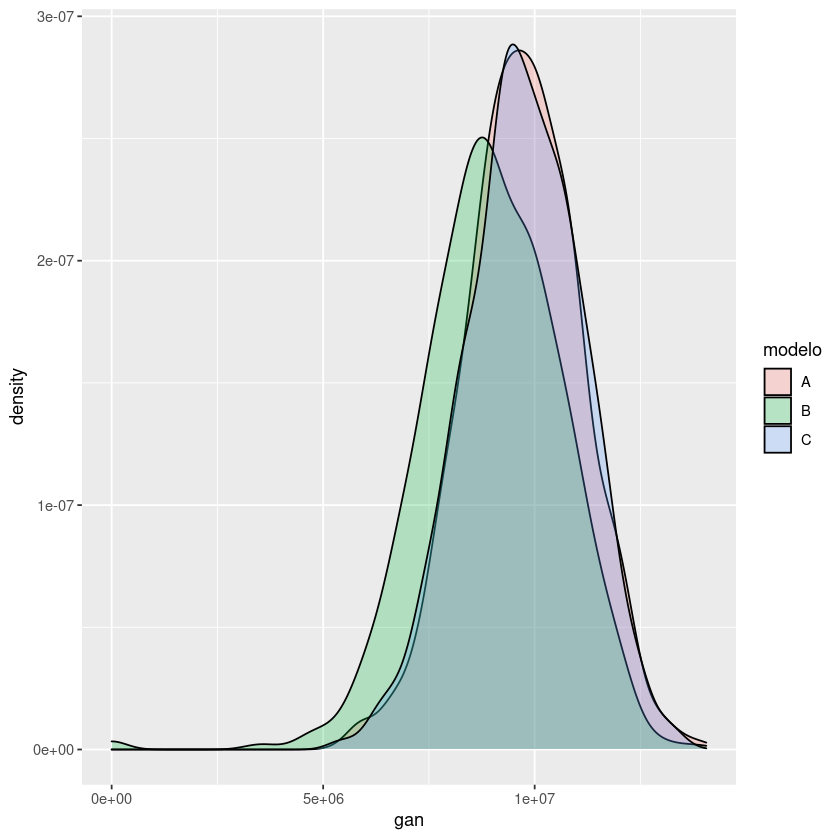

In [26]:
ggplot( tbl, aes(x=gan, fill=modelo)) + geom_density(alpha=0.25) 

Conclusión: Se observa que B es inferior, y que A y C son casi identicos